Building configuration for pair: ['JPM' 'CRM']


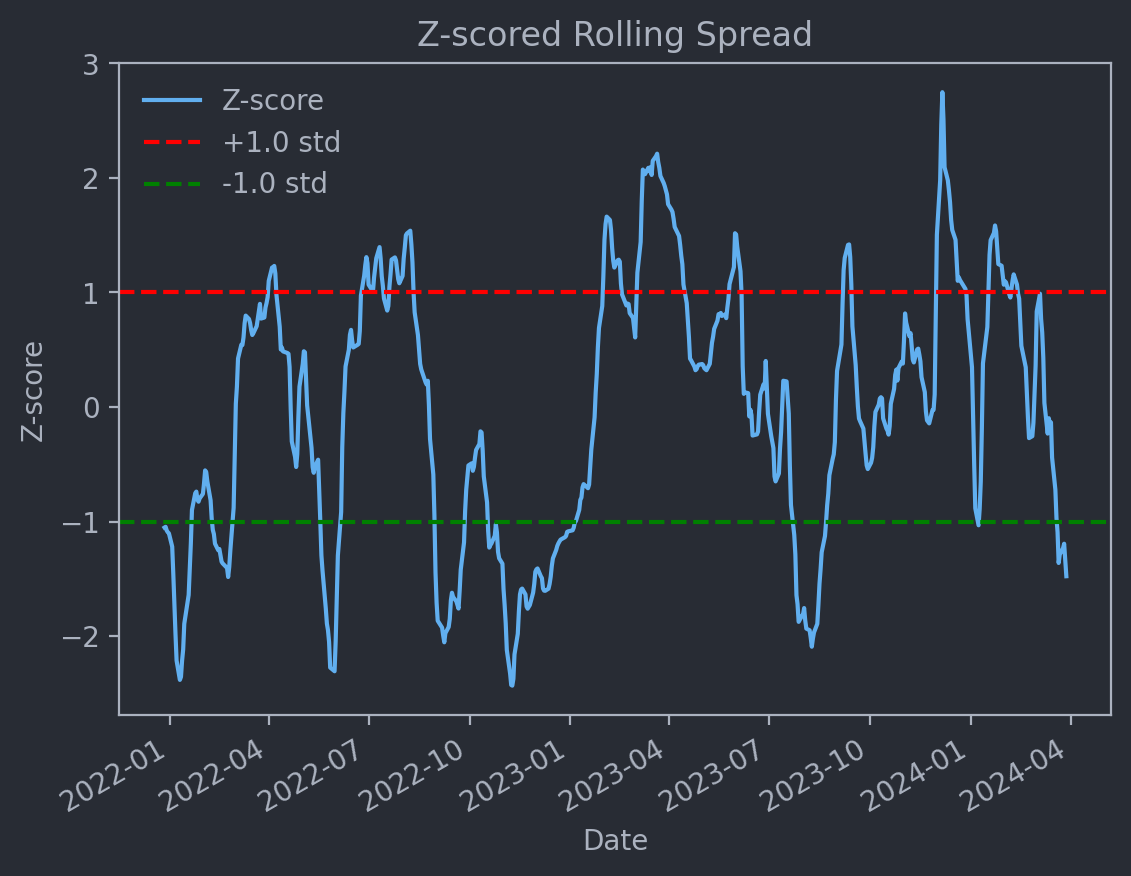


GradientBoostingRegressor

R2: 0.70, MAE: 0.40, MAPE: 385.65%


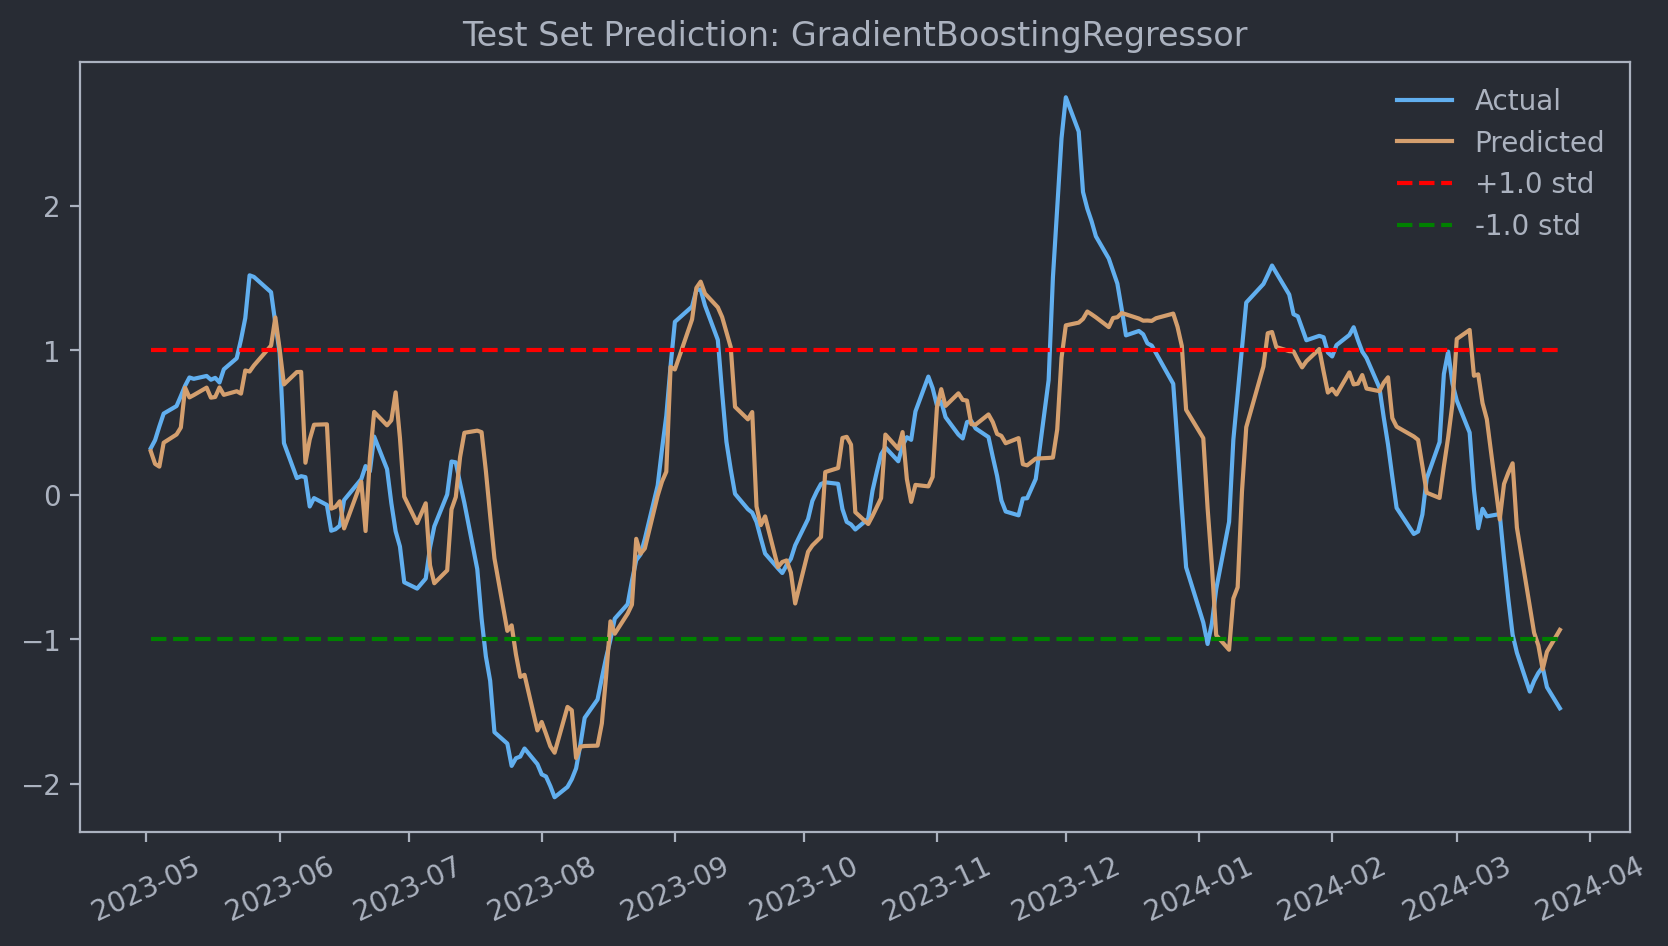

In [30]:
from typing import DefaultDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
import glob
warnings.filterwarnings('ignore')
plt.style.use('custom_onedark')




def norm_plot(df):
    df = df.copy()
    df = (df - df.mean()) / df.std()
    return df


def plot_zscore(pair_df, zscore_col='zscore_spread'):
    pair_df['zscore_spread'].plot(title='Z-scored Rolling Spread')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    # plt.axhline(0, color='black', label='Mean')
    plt.axhline(1.0, color='red', linestyle='--', label='+1.0 std')
    plt.axhline(-1.0, color='green', linestyle='--', label='-1.0 std')
    plt.legend(['Z-score', '+1.0 std', '-1.0 std'])
    plt.show()

def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df

from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def create_dataset(data, look_back, target_col="spread_close", split_sizes=[0.6, 0.2, 0.2], drop_cols: list = [], verbose=False):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size
    if verbose:
        print("\n------Dataset Information------")
        print(tabulate([
                ["Train", train_size, data.index[train_size].date()],
                ["Val", val_size, data.index[-val_size].date()],
                ["Test", test_size, data.index[-test_size].date()]],
            ["Set", "Size", "Date Cutoff"]))

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[-test_size:]
    return train_data, val_data, test_data


def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



data_dir = '../data/'
price_history_dir = data_dir + 'price_history/'
sentiment_dir = data_dir + 'sentiments/'
ti_dir = data_dir + 'technical_indicators/'

# Load Ticker Pairs
tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values
unique_pairs = pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')

# Load Ticker History, Sentiment, and Technical Indicators
class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

data = {}
for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))
    data[ticker] = TickerData(ticker)

# Functions for data processing
def join_sentiment(data, pair, add_sentiment_ma=DefaultDict()):
    pair_sentiment_df = pd.merge(data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
    if add_sentiment_ma.get('bool'):
        if not add_sentiment_ma.get('windows'):
            add_sentiment_ma['windows'] = [5, 10, 20, 40, 80]
        pair_sentiment_df = add_moving_averages(pair_sentiment_df, add_sentiment_ma.get('windows'), columns=pair_sentiment_df.columns)
    return pair_sentiment_df

def join_technical_indicators(data, pair):
    return pd.merge(data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))

# If window param is set, then spread is calculated on a rolling basis
# Adjusted function to fit on the training set only
def get_spread(S1_train, S2_train, S1_all, S2_all, window=None):
    s1_ols_train = sm.add_constant(S1_train)
    s1_ols_all = sm.add_constant(S1_all)

    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2_train, s1_ols_train, window=window).fit()
        spread_all = sm.regression.rolling.RollingOLS(S2_all, s1_ols_all, window=window).fit()
    else:
        spread_model = sm.OLS(S2_train, s1_ols_train).fit()
        beta_train = spread_model.params[S1_train.name]
        spread_all = S2_all - beta_train * S1_all

    return spread_all

# Adjust the calculate_spread function to use train data
def calculate_spread(pair_df, spread_window, ma_high, ma_low, train_end_idx):
    spread = get_spread(pair_df['Adj Close_S1'][:train_end_idx],
                        pair_df['Adj Close_S2'][:train_end_idx],
                        pair_df['Adj Close_S1'],
                        pair_df['Adj Close_S2'],
                        window=spread_window)
    pair_df['spread'] = spread

    ma_high_values = pair_df.spread.rolling(window=ma_high).mean()
    ma_low_values = pair_df.spread.rolling(window=ma_low).mean()
    std_high = pair_df.spread.rolling(window=ma_high).std()

    moving_zscore = (ma_low_values - ma_high_values) / std_high
    pair_df['zscore_spread'] = moving_zscore
    return pair_df



def setup_dataset(pair_df, look_back, drop_cols):
    train_data, val_data, test_data = create_dataset(pair_df, look_back=look_back, target_col="zscore_spread", drop_cols=drop_cols)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)
    X_test = pd.concat([X_val, X_test])
    y_test = pd.concat([y_val, y_test])
    return X_train, y_train, X_test, y_test

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")
    return metric_frame


# Main function to execute different configurations
def build_configuration_single(config):
    pair = pairs[config['PAIR_IDX']]
    pair_sentiment_df = join_sentiment(data, pair, config['ADD_SENTIMENT_MA'])
    pair_ti_df = join_technical_indicators(data, pair)
    pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")

    pair_df = calculate_spread(pair_df, config['SPREAD_WINDOW'], config['MA_HIGH'], config['MA_LOW']).dropna()
    X_train, y_train, X_test, y_test = setup_dataset(pair_df, config['LOOK_BACK'], config['DROP_COLS'])

    return pair_df, X_train, y_train, X_test, y_test

class Config:
    def __init__(self, pair_df=None, X_train=None, y_train=None, X_test=None, y_test=None, model=None, y_pred=None):
        self.pair_df = pair_df
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model
        self.y_pred = y_pred

    def update(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


def build_configuration(config):
    pair = pairs[config['PAIR_IDX']]
    print(f"Building configuration for pair: {pair}")
    pair_sentiment_df = join_sentiment(data, pair, config['ADD_SENTIMENT_MA'])
    pair_ti_df = join_technical_indicators(data, pair)
    pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")

    train_end_idx = int(len(pair_df) * config.get('TRAIN_SPLIT') if config.get('TRAIN_SPLIT') else int(len(pair_df) * 0.5))
    pair_df = calculate_spread(pair_df, config['SPREAD_WINDOW'], config['MA_HIGH'], config['MA_LOW'], train_end_idx).dropna()

    X_train, y_train, X_test, y_test = setup_dataset(pair_df, config['LOOK_BACK'], config['DROP_COLS'])
    plot_zscore(pair_df) if config['Verbose'] else None

    return Config(pair_df=pair_df, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

def plot_prediction(y_test, y_pred, model_name):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(y_test.index, y_test, label="Actual")
    ax.plot(y_test.index, y_pred, label=f"Predicted ({model_name})")
    ax.hlines(1.0, y_test.index[0], y_test.index[-1], color='red', linestyle='--', label='+1.0 std')
    ax.hlines(-1.0, y_test.index[0], y_test.index[-1], color='green', linestyle='--', label='-1.0 std')
    plt.title(f"Test Set Prediction: {model_name}")
    plt.xticks(rotation=25)
    ax.legend(['Actual', 'Predicted', '+1.0 std', '-1.0 std'])
    plt.show()


def train(model, config, plot=True):
    model.fit(config.X_train, config.y_train)
    config.y_pred = model.predict(config.X_test)
    config.model = model
    model_name = model.__class__.__name__
    print(f"\n{model_name}")
    metrics = calculate_metrics(config.y_test, config.y_pred)
    if plot:
        plot_prediction(config.y_test, config.y_pred, model_name)
    return metrics




current_config =  {
        'PAIR_IDX': 1,
        'ADD_SENTIMENT_MA': {'bool': True, 'windows': [5, 10, 20, 40, 80]},
        'SPREAD_WINDOW': None,
        'MA_HIGH': 60,
        'MA_LOW': 5,
        'LOOK_BACK': 3,
        'DROP_COLS': [],
        'Verbose': 1,
    }


built_config = build_configuration(current_config)



from sklearn.ensemble import GradientBoostingRegressor
model_gbm = GradientBoostingRegressor(n_estimators=100, random_state=42)
metrics = train(model_gbm, built_config, plot=True)

built_config.model = model_gbm

In [25]:
built_config.model

In [ ]:
%matplotlib inline

from datetime import datetime
from itertools import product
import pickle

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

MA_HIGH = [45, 60]
MA_LOW = [1, 3, 10]
look_back = [1, 3, 5, 7]

for i in range(10):
    for ma_high, ma_low, lb in product(MA_HIGH, MA_LOW, look_back):
        current_config = {
            'PAIR_IDX': i,
            'ADD_SENTIMENT_MA': {'bool': True, 'windows': [5, 10, 20, 40, 80]},
            'SPREAD_WINDOW': None,
            'MA_HIGH': ma_high,
            'MA_LOW': ma_low,
            'LOOK_BACK': lb,
            'DROP_COLS': [],
            'Verbose': 0,
        }

        base_models = [
            LinearRegression(),
            GradientBoostingRegressor(random_state=42),
            LGBMRegressor(random_state=42, verbose=-1),
            RandomForestRegressor(n_estimators=100, random_state=42),
            # SVR(),
            # KNeighborsRegressor(),
        ]

        for model in base_models:
            print(current_config)
            built_config = build_configuration(current_config)

            train(model, built_config, plot=False)

            with open(f'models/{model.__class__.__name__}{datetime.now().strftime("%Y%m%d%H%M")}.pkl', 'wb') as f:
                pickle.dump(model, f)


        ## Run your models 
        built_config = build_configuration(current_config)

        ### Train your model



        ## Save Results like
        # built_config.model = model
        # built_config.y_pred = y_pred
        # built_config.metrics = metrics


        ### Pickle your model
        # with open(f'models/{model.__class__.__name__}{datetime.now().strftime("%Y%m%d%H%M")}.pkl', 'wb') as f:
    